In [9]:
from torch import nn, Tensor

# Creator imports
from elasticai.creator.nn import Sequential
from elasticai.creator.nn.fixed_point import Linear, Tanh, BatchNormedLinear

from package.dnn.template.dataset.autoencoder import prepare_training
from package.dnn.dnn_handler import Config_ML_Pipeline, DefaultSettings_MLPipe
from package.yaml_handler import yaml_config_handler
from package.dnn.pytorch_dataclass import (Config_Dataset, DefaultSettingsDataset)
from package.dnn.pytorch_handler import __model_settings_common
from package.plot.plot_dnn import results_training
from package.dnn.pytorch_dataclass import DefaultSettingsTrainMSE
from package.dnn.pytorch_handler import ModelRegistry
from package.dnn.pytorch_dataclass import Config_PyTorch
from datetime import datetime, date
from package.dnn.pytorch_pipeline import do_train_autoencoder

## Prepare Trainingsconfiguration

In [10]:
yaml_handler = yaml_config_handler(DefaultSettings_MLPipe, 'config', 'Config_DNN')
dnn_handler = yaml_handler.get_class(Config_ML_Pipeline)
yaml_name_index='Config_AE'


yaml_data = yaml_config_handler(DefaultSettingsDataset, dnn_handler.get_path2config, f'{yaml_name_index}_Dataset')
config_data = yaml_data.get_class(Config_Dataset)

models_available = ModelRegistry()

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_DNN.yaml
... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_AE_Dataset.yaml


### Dataset

In [11]:
dataset = prepare_training(settings=config_data, do_classification=False,
                            mode_train_ae=dnn_handler.autoencoder_mode, noise_std=dnn_handler.autoencoder_noise_std)

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/access_cloud.yaml
... loading and processing the dataset
... do data normalization
... for training are 15894 frames with each 32 points available
... used data points for training: in total 6 classes with 15894 samples
	class 0 (Neuron #0) --> 1393 samples
	class 1 (Neuron #1) --> 1696 samples
	class 2 (Neuron #2) --> 4251 samples
	class 3 (Neuron #3) --> 3427 samples
	class 4 (Neuron #4) --> 2083 samples
	class 5 (Neuron #5) --> 3044 samples


## Model

#### Hyperparameter

In [18]:
total_bits = 8
frac_bits = 5
bn_affine = True
num_steps = 2**8
interval = (-4, 3.96875)

### Quantized Model without BatchNorm

In [19]:
@models_available.register
class dnn_ae_v1_Q_wo_BN(__model_settings_common):
    """Class of an autoencoder with Dense-Layer for feature extraction"""
    def __init__(self, input_size=32, output_size=3):
        super().__init__('Autoencoder')
        self.model_shape = (1, input_size)
        self.model_embedded = True
        iohiddenlayer = [input_size, 20, 14, output_size]
        do_train_bias = True
        do_train_batch = True

        # --- Encoder Path
        self.encoder = Sequential(
            Linear(in_features=iohiddenlayer[0], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=False),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=False),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[3], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=True),
        )
        # --- Decoder Path
        self.decoder = Sequential(
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps),
            Linear(in_features=iohiddenlayer[3], out_features=iohiddenlayer[2], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=True),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[2], out_features=iohiddenlayer[1], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=False),
            Tanh(total_bits=total_bits, frac_bits=frac_bits, num_steps=num_steps, sampling_intervall=interval),
            Linear(in_features=iohiddenlayer[1], out_features=iohiddenlayer[0], bias=do_train_bias, total_bits=total_bits, frac_bits=frac_bits, parallel=False),
        )

    def forward(self, x: Tensor) -> [Tensor, Tensor]:
        encoded = self.encoder(x)
        return encoded, self.decoder(encoded)
    
    def forward_first_layer(self, x: Tensor) -> Tensor:
        return self.encoder[0](x)
    
    def create_design(self, name):
        encoder = self.encoder.create_design(f"{name}_encoder")
        decoder = self.decoder.create_design(f"{name}_decoder")
        return encoder, decoder
        

## Training

In [20]:
default_train = DefaultSettingsTrainMSE
default_train.model_name = dnn_ae_v1_Q_wo_BN.__name__
yaml_nn = yaml_config_handler(default_train, dnn_handler.get_path2config, f'{yaml_name_index}_Training')
config_train = yaml_nn.get_class(Config_PyTorch)

dnn_handler.do_plot  = False

... read YAML file: /home/silas/PycharmProjects/denspp.offline/3_Python/config/Config_AE_Training.yaml


In [21]:
q_model_wo_bn = models_available.build_model('dnn_ae_v1_Q_wo_BN')
path4vhdl = f'vhdl/run_{date.today()}_{datetime.utcnow().strftime("%H%M")}'

q_model_wo_bn_stats = dict()

{'model': <class 'torch.nn.modules.container.Sequential'>}


In [23]:
q_model_wo_bn_stats['metrics'], q_model_wo_bn_stats['data_result'], q_model_wo_bn_stats['path2folder'] = do_train_autoencoder( #metrics, data_result, path2folder
        config_ml=dnn_handler, config_data=config_data, config_train=config_train,
        used_dataset=dataset, used_model=q_model_wo_bn, calc_custom_metrics=['dsnr_all'])


Print summary of model




Using PyTorch with Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz (@ 0.800 GHz) on Linux
dict_keys(['snr_in', 'snr_in_cl', 'snr_out', 'snr_out_cl', 'dsnr_all', 'dsnr_cl'])

Training starts on 12:24:36
... results of epoch 1/30 [3.33 %]: train_loss = 0.00641,	valid_loss = 0.00629,	delta_loss = 0.000119
... results of epoch 2/30 [6.67 %]: train_loss = 0.00625,	valid_loss = 0.00626,	delta_loss = -0.000006
... results of epoch 3/30 [10.00 %]: train_loss = 0.00627,	valid_loss = 0.00626,	delta_loss = 0.000010
... results of epoch 4/30 [13.33 %]: train_loss = 0.00627,	valid_loss = 0.00635,	delta_loss = -0.000084
... results of epoch 5/30 [16.67 %]: train_loss = 0.00628,	valid_loss = 0.00644,	delta_loss = -0.000155
... results of epoch 6/30 [20.00 %]: train_loss = 0.00627,	valid_loss = 0.00618,	delta_loss = 0.000094
... results of epoch 7/30 [23.33 %]: train_loss = 0.00622,	valid_loss = 0.00626,	delta_loss = -0.000047
... results of epoch 8/30 [26.67 %]: train_loss = 0.00

## Plotting Results

/home/silas/PycharmProjects/denspp.offline/3_Python/package/plot/plot_dnn.py:149: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=0.5)


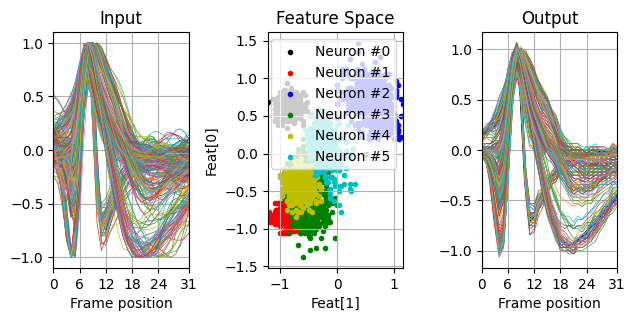

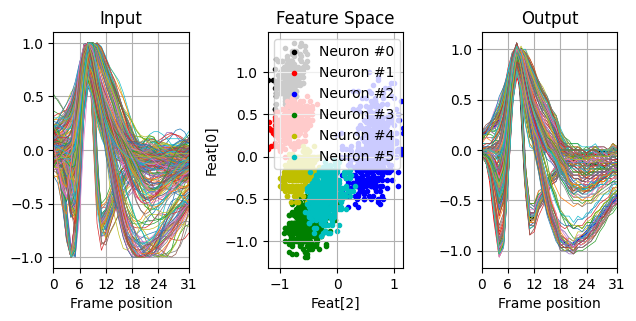

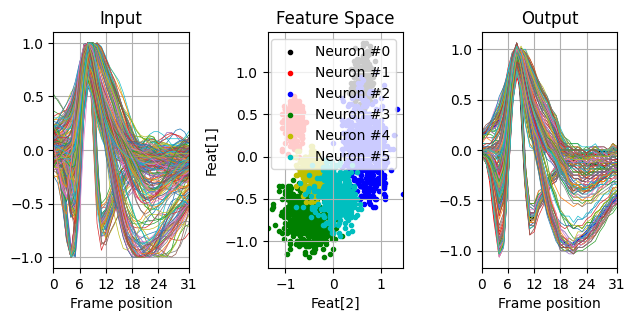

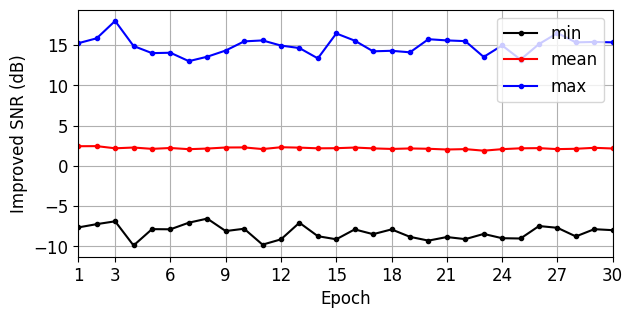

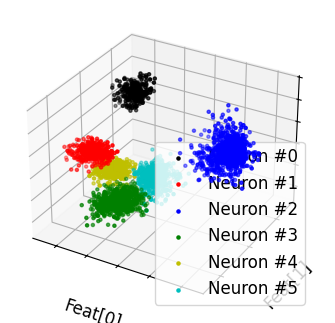

In [24]:
used_first_fold = [key for key in q_model_wo_bn_stats["metrics"].keys()][0]
results_training(
    path=q_model_wo_bn_stats["path2folder"], cl_dict=q_model_wo_bn_stats["data_result"]['cl_dict'], feat=q_model_wo_bn_stats["data_result"]['feat'],
    yin=q_model_wo_bn_stats["data_result"]['input'], ypred=q_model_wo_bn_stats["data_result"]['pred'], ymean=dataset.get_mean_waveforms,
    yclus=q_model_wo_bn_stats["data_result"]['valid_clus'], snr=q_model_wo_bn_stats["metrics"][used_first_fold]['dsnr_all'],
    show_plot=dnn_handler.do_block
)